In [2]:
# activate package, basic imports + load data
include("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/analysis_fixtures.jl")
include("/Users/federicoclaudi/Documents/Github/LocomotionControl/analysis/behavior/analysis_visuals.jl")
using Dierckx
using JSON: JSON
using DataFrames: DataFrame
import JSONTables: objecttable, jsontable
import jcontrol: State, movingaverage

  Activating project at `~/Documents/Github/LocomotionControl/analysis/behavior`


@Info (Main):  Loaded 1021 trials 
  ╰──────────────────────────────────────────────── 


                      Wed, 11 May 2022 08:17:50 
@Info (Main):  After tortuosity analysis, discarded 9.109% of trials | 928

 
  │                trials left 
  ╰──────────────────────────────────────────────── 
                      Wed, 11 May 2022 08:17:52 


## Generate dataset for RNN training
It takes the tracking data processed through the Julia behavior analysis code and creates a dataset for training an RNN on.

The frist step is to get the trial's trajectory in the track's curvilinear coordinates system and to upsample the data so that they are
expressed at an arbitrary framerate $\Delta t$.

Next, we sample `N` random time points from each trial and take the next `T` seconds of the trial as a training sample (to avoid training over an entire trial).
Then, at each frame in the selected chunk of trial we get the track's curvature at each $\Delta s$ point from the mouse's current position to `S` cm later.

In [3]:
# PARAMS
Δt = 0.005  # time step duration of upsampled trial
N = 3    # number of chunks per trial
T = .66  # duration of each trial "chunk" for training
Δs = 2.5  # distance between sampling's of the track's curvature
S = 20   # lookahead distance for track's curvature.
N_trials = 50  # number of trials to use

50

### Prepare tracking data
Load tracking data, turn into track's curvilinear coordinates and upsample

In [4]:

function upsample_framerate(x, Δt)
    t_original = 0:1/60:(length(x)/60 + 1)
    t_original = t_original[1:length(x)]
    t_upsample = 1:Δt:(t_original[end])
    spl = Spline1D(t_original, x; k=2) # k: order of interpolant; can be between 1-5
    return spl(t_upsample)
end

mutable struct CurvilinearCoordsTrials
    x::Vector
    y::Vector
    s::Vector
    n::Vector
    ψ::Vector
    V::Vector  # velocity vector: V = √(v² + u²)
    ω::Vector
    V̇::Vector  # acceleration
    ω̇::Vector  # angular acceleration
end

function CurvilinearCoordsTrials(states::Vector{State})
    v = upsample_framerate(sqrt.(getfield.(states, :v).^2 + getfield.(states, :u).^2), Δt)
    ω = upsample_framerate(getfield.(states, :ω), Δt)

    v̇ = [0, (movingaverage(diff(v), 21) / Δt)...]
    ω̇ = [0, (movingaverage(diff(ω), 21) / Δt)...]

    return CurvilinearCoordsTrials(
        upsample_framerate(getfield.(states, :x), Δt),
        upsample_framerate(getfield.(states, :y), Δt),    
        upsample_framerate(getfield.(states, :s), Δt),
        upsample_framerate(getfield.(states, :n), Δt),
        upsample_framerate(getfield.(states, :ψ) .- getfield(states[1], :ψ), Δt),
        upsample_framerate(v, Δt),
        upsample_framerate(ω, Δt),
        v̇,
        ω̇,
    )

end

CurvilinearCoordsTrials

In [5]:
trial_states(trial) = map(frame->State(trial, frame, FULLTRACK; v=trial.v[frame]), 1:length(trial.x))
ctrials = map(trial -> CurvilinearCoordsTrials(trial_states(trial)), trials[1:N_trials])
@info "Got $(length(ctrials)) trials"
nothing

@Info (Main):  Got 50 trials 
  ╰──────────────────────────────────────────────── 
                      Wed, 11 May 2022 08:18:12 


### Step 2
Get each frame from the data and take the curvature in the track's section ahead.

In [13]:
import OrderedCollections: OrderedDict

tot_frames = sum(map(t->length(t.x), ctrials))
@info "Number of frames $(tot_frames)"

waypoints = collect(0:Δs:S)
waypoints_idxs = 1:length(waypoints)
ks = collect(Symbol("k_", i)=>zeros(Float64, tot_frames) for i in 1:length(waypoints_idxs))


data = OrderedDict(
    :n => zeros(Float64, tot_frames),
    :s => zeros(Float64, tot_frames),
    :ψ => zeros(Float64, tot_frames),
    :V => zeros(Float64, tot_frames),
    :ω => zeros(Float64, tot_frames),
    :V̇ => zeros(Float64, tot_frames),
    :ω̇ => zeros(Float64, tot_frames),
    ks...
)

@Info (Main):  Number of frames 35519 
  ╰──────────────────────────────────────────────── 
                      Wed, 11 May 2022 08:36:55 


OrderedDict{Symbol, Vector{Float64}} with 16 entries:
  :n   => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :s   => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :ψ   => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :V   => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :ω   => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :V̇   => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :ω̇   => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :k_1 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :k_2 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :k_3 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :k_4 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, …
  :k_5 => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [18]:
i = 0
for (n, trial) in enumerate(ctrials)
    n % 100 == 0 && println(n)

    for frame in 1:length(trial.x)
        i += 1
        # get relevant S vector from track
        s̄ = FULLTRACK.S .- trial.s[frame]
        start = argmin(s̄ .^ 2)
        stop = findlast(s̄ .<= S)
        # @assert stop > start
        # @assert FULLTRACK.S[stop] <= (trial.s[frame]+S)

        svec = FULLTRACK.S[start:stop]
        for (I, sval) in zip(waypoints_idxs, waypoints)
            idx = findfirst((svec .- svec[1]) .> sval)
            idx = isnothing(idx) ? 1 : idx
            # push!(trial_curv[I], svec[idx])

            data[Symbol("k_", I)][i] = FULLTRACK.κ(svec[idx])
        end
        for var in (:n, :s, :ψ, :V, :ω, :V̇, :ω̇)
            data[var][i] = getfield(trial, var)[frame]
        end
    end
end


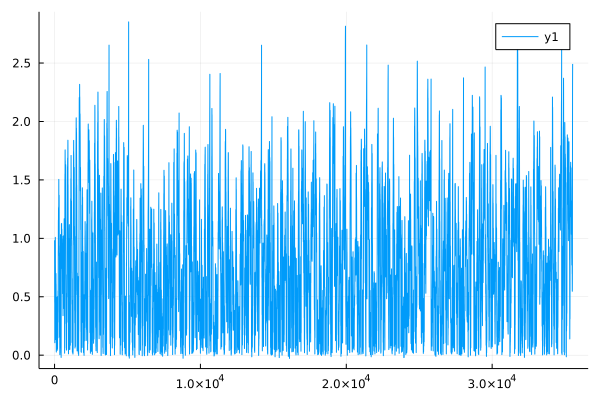

In [19]:
plot(data[:n])

### Step 3
save the data

In [20]:
savepath = "/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/CNN/dataset"
df = DataFrame(data)
open(joinpath(savepath, "data.json"), "w") do f
    write(f, objecttable(df))
end


11484705